[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI4ChemS/CHE-1147/blob/main/tutorials/tutorial_supervised_learning.ipynb)

# Supervised Learning Workflow

## Machine learning for discovery of MOFs for gas separation applications

In this notebook we will build machine learning models that can predict the gas uptake (carbon dioxide and methane) of metal-organic frameworks (MOFs), which are crystalline materials consisting of inorganic metal nodes linked by organic linkers. The discovery of MOFs for carbon capture is needed for emission reduction technologies, as these materials can efficiently adsorb and store greenhouse gases like CO$_2$. Machine learning accelerates this discovery process by enabling the prediction of gas uptake properties from structural and chemical descriptors, reducing the need for time-consuming and costly experiments or simulations.

机器学习在金属有机框架（MOFs）气体分离应用中的发现
在本笔记本中，我们将构建机器学习模型，用于预测金属有机框架（MOFs）的气体吸附量（包括二氧化碳和甲烷）。MOFs 是由无机金属节点通过有机连接体连接形成的晶体材料。为了实现碳捕集，MOFs 的发现对于减排技术至关重要，因为这些材料能够高效吸附和储存温室气体如 CO₂。机器学习通过利用结构和化学描述符预测气体吸附性能，加速了这一发现过程，从而减少了耗时且成本高昂的实验或模拟需求。


![MOF building principle](https://github.com/AI4ChemS/CHE-1147/blob/main/assets/mof_building_principle.png?raw=1)

There are two main **learning goals** for our tutorial:

1. Understand the typical workflow for machine learning in chemistry and materials. We will cover exploratory data analysis (EDA) and supervised learning (KRR).
理解化学与材料科学中机器学习的典型工作流程。我们将涵盖探索性数据分析（EDA）和监督学习（KRR）。

2. Get familiar with some Python packages that are useful for data analysis and visualization.

At the end of the exercise, you will produce plot like the one below, comparing the predictions of your model against computed values from GCMC simulations.
The histograms show the distributions of the errors on the training set (left) and on the test set (right).


理解化学与材料科学中机器学习的典型工作流程。我们将涵盖探索性数据分析（EDA）和监督学习（KRR）。

熟悉一些在数据分析和可视化中非常有用的 Python 包。

在练习结束时，你将生成如下图所示的图表，将模型的预测结果与 GCMC 模拟计算值进行对比。
直方图显示了训练集（左）和测试集（右）上的误差分布。


<img src="https://github.com/AI4ChemS/CHE-1147/blob/main/assets/result.gif?raw=1" alt="Parity interactive" width="700"/>

We will be using scikit-learn for modeling. The [sklearn documentation](https://scikit-learn.org/stable/user_guide.html) is a great source of reference with many explanations and examples. Also, we use Pandas dataframe (df) for data manipulation. You can select columns using their name by running `df[columnname]`. If at any point you think that the dataset is too large for your computer, you can select a subset using `df.sample()` or by making the test set larger in the train/test split (section 2).
<img src="https://github.com/AI4ChemS/CHE-1147/blob/main/assets/result.gif?raw=1" alt="Parity interactive" width="700"/>  

我们将使用 scikit-learn 进行建模。[sklearn 文档](https://scikit-learn.org/stable/user_guide.html) 是一个很好的参考来源，包含大量解释和示例。同时，我们使用 Pandas 的 DataFrame（df）进行数据操作。你可以通过运行 `df[columnname]` 来选择指定列。如果在某个阶段你觉得数据集对你的电脑来说过大，可以使用 `df.sample()` 选择一个子集，或者在训练/测试划分（第 2 节）中增大测试集的比例。


> **Credit:** This notebook is adapted from our (Mohamad Moosavi and Kevin Jablonka) lecture and hands-on session in MolSim winter school in Amsterdam.
> - [MolSim](https://www.compchem.nl/molsim/) course website.
> - [kjappelbaum/ml_molsim](https://github.com/kjappelbaum/ml_molsim) on GitHub.

## 0. Setup programming environment

### 0.1 Installing packages

If you are running this notebook locally after cloning [UofT-CHE1147](https://github.com/AI4ChemS/CHE1147) repo, simply install the conda environment

```python
conda env create -f environment.yml
conda activate che1147
```

If you are running this notebook on Google Colab, please uncomment the lines below (remove the `#`) and execute the cell.

In [ ]:
# import os, sys, urllib.request

# !pip install -r https://github.com/AI4ChemS/CHE1147/raw/refs/heads/main/requirements_colab.txt

# CHE1147_DIR = "/content/che1147_files"
# os.makedirs(CHE1147_DIR, exist_ok=True)
# data_URL = "https://github.com/AI4ChemS/CHE1147/raw/refs/heads/main/data/MOF_CoRE2019.csv"
# descriptors_URL = "https://github.com/AI4ChemS/CHE1147/raw/refs/heads/main/tutorials/MOF_descriptors.py"

# local_descriptor_path = os.path.join(CHE1147_DIR, "MOF_descriptors.py")
# urllib.request.urlretrieve(descriptors_URL, local_descriptor_path)

# local_data_path = os.path.join(CHE1147_DIR, "MOF_CoRE2019.csv")
# urllib.request.urlretrieve(data_URL, os.path.join(CHE1147_DIR, "MOF_CoRE2019.csv"))

# if CHE1147_DIR not in sys.path:
#     sys.path.append(CHE1147_DIR)


### 0.2 Import packages we will need

> Note, if you are using colab, you may need to install some of the packages.

In [2]:
# basics
import os
import numpy as np
import pprint as pp            #导入 pretty print，用于美观地打印复杂的数据结构（如字典、列表），方便调试和查看内容。

# pandas is used to read/process data   #用于 生成数据分析报告，自动展示数据统计信息、缺失值、分布、相关性等。
from ydata_profiling import ProfileReport

# machine learning dependencies
# scaling of data 数据标准化 / 缩放
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# train/test split       用于 把数据集分成训练集和测试集
from sklearn.model_selection import train_test_split

# model selection 模型选择与超参数优化
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# the KRR model
from sklearn.kernel_ridge import KernelRidge
# linear model
from sklearn.linear_model import LinearRegression, SGDRegressor

# pipeline to streamline modeling pipelines 用于 将多个处理步骤串联起来，例如先标准化数据，再做降维，最后训练模型，便于统一管理和交叉验证。
from sklearn.pipeline import Pipeline

# principal component analysis ：用于 降维，将高维特征投影到低维空间，同时保留尽可能多的方差信息，减少冗余和噪声。
from sklearn.decomposition import PCA

# polynomial kernel 计算特征之间的 多项式核函数，在核回归或支持向量机中常用于处理非线性关系。
from sklearn.metrics.pairwise import polynomial_kernel

# Dummy model as baseline 计算特征之间的 多项式核函数，在核回归或支持向量机中常用于处理非线性关系。
from sklearn.dummy import DummyClassifier, DummyRegressor

# Variance Threshold for feature selection VarianceThreshold：删除 方差低的特征（几乎没有变化的特征），减少冗余。
                                             # SelectFromModel：根据训练好的模型的重要性指标选择特征，例如根据回归系数或树模型的特征重要性。
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

# metrics to measure model performance. accuracy_score：准确率, precision_score：精确率, recall_score：召回率, f1_score：F1 分数（精确率和召回率的调和平均）,回归指标, mean_absolute_error（MAE）：平均绝对误差

# mean_squared_error（MSE）：均方误差, max_error：最大误差, mean_absolute_percentage_error（MAPE）：平均绝对百分比误差

#这一段导入的都是 模型、数据处理工具和评价指标，为构建、优化和评估机器学习模型做准备。
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error)

# save/load models 常用于 保存训练好的模型 到文件，或者从文件加载模型，而不必每次都重新训练。
import joblib

# For the permutation importance implementation Parallel 和 delayed 用于 并行计算，加速耗时操作，例如在多核 CPU 上同时计算每个特征的重要性。
from joblib import Parallel
from joblib import delayed

from sklearn.metrics import check_scoring         #用于 验证和获取模型的评分函数，确保评分指标与模型兼容，例如 MAE、R² 等。
from sklearn.utils import Bunch                   #Bunch 是一种类似字典的数据结构，但可以通过 点（.）访问属性，方便存储数据或配置。
from sklearn.utils import check_random_state      #check_random_state：确保随机数生成器的一致性和可复现性，例如在交叉验证或打乱数据时使用。
from sklearn.utils import check_array             #检查输入数据是否为合法的 NumPy 数组，并可进行必要的类型转换或缺失值处理，保证模型输入安全。

# plotting
import seaborn as sns           #seaborn：基于 matplotlib 的高级绘图库，方便画出漂亮的统计图（如热力图、分布图、箱线图）。
import matplotlib.pyplot as plt     #matplotlib.pyplot：Python 最常用的绘图库，用于绘制各种图表，如折线图、散点图、直方图等。
%matplotlib inline       #让绘制的图 直接显示在 Notebook 内 而不是弹出新窗口。

ModuleNotFoundError: No module named 'ydata_profiling'

### 0.3 Fix the random seed

In [4]:
# add code here
#RANDOM_SEED 目的是控制随机性，保证在不同时间或不同机器上运行代码时，结果保持一致。
##FILLME 表示你需要自己填入一个具体的数字

#RANDOM_SEED = #FILLME
RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)

 $\color{Aqua}{\textsf{Short question}}$
- We declared a global variable to fix the random seed (`RANDOM_SEED`). Why did we do this?  

### 0.4 Import the data

The dataset used in this tutorial originates from the publication ["Understanding the diversity of the metal-organic framework ecosystem"](https://doi.org/10.1038/s41467-020-17755-8), which explores the application of machine learning for predicting gas adsorption properties in MOFs. This dataset contains geometric and chemical descriptors, as well as simulated gas uptake values, enabling the development and evaluation of regression models for materials discovery.

本教程使用的数据集来源于论文《Understanding the diversity of the metal-organic framework ecosystem》，该论文探讨了机器学习在预测 MOFs 气体吸附性能中的应用。该数据集包含几何和化学描述符，以及模拟的气体吸附量，使得开发和评估用于材料发现的回归模型成为可能。


In [6]:
import pandas as pd
# load data locally 检测是否在 Colab 运行
#get_ipython() 返回当前的 IPython 环境信息.如果字符串中包含 'google.colab'，说明代码在 Google Colab 中运行。这个变量用于后续选择不同的数据路径。

running_in_colab = 'google.colab' in str(get_ipython())


#设置数据路径
#如果在 Colab：数据存放在 /content/che1147_files 文件夹，完整文件路径：/content/che1147_files/MOF_CoRE2019.csv

#如果在 本地：数据存放在 ../data 文件夹（相对路径）。完整文件路径：../data/MOF_CoRE2019.csv

# os.path.join() 用于 拼接路径，保证在不同操作系统下都能正确处理斜杠。

if running_in_colab:
    DATA_DIR = "/content/che1147_files"
    DATA_FILE = os.path.join(DATA_DIR, "MOF_CoRE2019.csv")
else:
    DATA_DIR = "../data"
    DATA_FILE = os.path.join(DATA_DIR, "MOF_CoRE2019.csv")



#尝试从本地读取数据：使用 Pandas 的 read_csv() 读取 CSV 文件，存入 df（DataFrame）。

#成功读取后打印 ✅，并显示数据形状 df.shape（行数 × 列数）。
#捕获 FileNotFoundError（本地 CSV 不存在）。

try:
    df = pd.read_csv(DATA_FILE)
    print(f"✅ Loaded data from {DATA_FILE}, shape = {df.shape}")


#如果本地文件不存在。尝试从 GitHub 远程 URL 读取数据，保证即使本地没有文件也能继续执行。

#成功读取后打印 🌐 并显示数据形状

except FileNotFoundError:
    # Fallback: try to load from GitHub raw URL
    url = "https://github.com/AI4ChemS/CHE1147/raw/refs/heads/main/data/MOF_CoRE2019.csv"
    try:
        df = pd.read_csv(url)
        print(f"🌐 Loaded data from GitHub, shape = {df.shape}")

 # 如果远程也失败，打印 ❌ 提示找不到文件，然后重新抛出异常以终止程序。
    except Exception as e:
        print(f"❌ Could not find {DATA_FILE} locally or on GitHub.")
        raise e

🌐 Loaded data from GitHub, shape = (5014, 331)


In [7]:
df.head()
#显示数据表前 5 行。

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-2,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K
0,XAGCUE_clean,0.00,2.87682,6.41175,6.41175,487.410,0.000000,0.0000,0.101882,0.21558,...,10752.0,10752.0,242.0856,523.7232,844.9008,1049.6448,1.266370,3.120211,1.810078,2.173372
1,SOBZEQ_clean,2298.52,5.44324,7.06044,7.04565,0.000,0.738273,0.6363,0.000000,0.00000,...,2240.0,2544.0,58.2840,130.2840,194.2144,231.0000,8.224130,17.486748,4.560643,11.578465
2,AVAQIX01_clean,0.00,3.61603,5.36267,5.34980,600.353,0.000000,0.0000,0.226377,0.30062,...,3040.0,2688.0,91.7328,204.2656,276.2848,265.7760,3.694178,5.849020,3.859973,5.251466
3,INURIS_clean,0.00,3.09799,5.07769,4.57779,253.440,0.000000,0.0000,0.077296,0.09856,...,12720.0,13728.0,301.4544,713.6976,1037.0160,1127.9280,1.007227,4.092395,2.032925,3.728986
4,KEDNOY_clean,0.00,3.63243,4.98967,4.98020,519.714,0.000000,0.0000,0.238159,0.28890,...,2064.0,1920.0,72.0852,153.0144,199.7088,218.5200,3.617103,6.170669,3.924974,4.888655


<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>Use something like <code>pd.options.display.max_columns=100</code> to adjust how many columns are shown.<code>pd.options.display.max_columns=100</code>  would show at maximum 100 columns. </li>
</ul>
</details>

Let's also get some basic information ...

In [8]:
df.info()
#快速查看数据的总体信息，尤其是列名、数据类型、非空值数量和内存使用情况。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Columns: 331 entries, MOFname to CH4 uptake at 65 bar and 298K
dtypes: float64(330), object(1)
memory usage: 12.7+ MB


 $\color{Aqua}{\textsf{Short question}}$
- How many materials are in the dataset?
- Which datatypes do we deal with?

### 0.5 Understanding the data
作为描述符，我们将使用孔隙几何描述符，例如密度、孔体积等，以及修正自相关函数（RACs）来描述 MOFs 的化学特性。我们的数据集包含 MOFs 的四个性能属性：

* CO₂ 在 0.15 bar 和 298K 下的吸附量
* CO₂ 在 16 bar 和 298K 下的吸附量
* CH₄ 在 5.8 bar 和 298K 下的吸附量
* CH₄ 在 65 bar 和 298K 下的吸附量

As descriptors we will use pore geometric descriptors, such as density, pore volume, etc. and [revised autocorrelation functions](https://www.nature.com/articles/s41467-020-17755-8) (RACs) for describing chemistry of MOFs. Our dataset has four properties for MOFs:
- CO2 uptake at 0.15 bar and 298K
- CO2 uptake at 16 bar and 298K
- CH4 uptake at 5.8 bar and 298K
- CH4 uptake at 65 bar and 298K




Let's start with a simple one that is the high-pressure CO$_2$ uptake `df["CO2 uptake at 16 bar and 298K"]`. This is the amount of CO$_2$ (mmol) the MOF can load per gram.

我们先从一个简单的属性开始，即高压下的 CO₂ 吸附量：`df["CO2 uptake at 16 bar and 298K"]`。它表示 MOF 每克材料能够吸附的 CO₂ 数量（单位：mmol）。


Below, we define three global variables (hence upper case), which are the *names* of our feature and target columns. We will use the `TARGET` for the actual regression and the `TARGET_BINARY` only for the stratified train/test split. The `FEATURES` variable is a list of column names of our dataframe. We imported the names of descriptors from `MOF_descriptors.py`.


下面，我们定义了三个全局变量（因此使用大写字母），它们分别是特征列和目标列的名称。

* `TARGET` 用于实际的回归模型
* `TARGET_BINARY` 仅用于分层训练/测试集划分
* `FEATURES` 是数据框中描述符列名的列表

描述符的列名是从 `MOF_descriptors.py` 文件中导入的。


In [ ]:
# name of descriptors
#从 MOF_descriptors.py 文件中导入若干个 描述符列表。这些变量中，每一个都代表一组特征（列名），用于表示 MOF 的不同结构或化学特征。
from MOF_descriptors import geometric_descriptors, linker_descriptors, metalcenter_descriptors, functionalgroup_descriptors, summed_linker_descriptors, summed_metalcenter_descriptors, summed_functionalgroup_descriptors

#定义目标变量（也就是我们要预测的值）。在这里，目标是：MOF 在 16 bar 压力、298K 温度下的 CO₂ 吸附量。
TARGET = "CO2 uptake at 16 bar and 298K"



#将多组描述符列表拼接（合并）在一起，生成一个大的特征列表。
#这些特征列将作为输入（X），TARGET 将作为输出（y），供机器学习模型训练使用。
FEATURES = (
    geometric_descriptors
    + summed_functionalgroup_descriptors
    + summed_linker_descriptors
    + summed_metalcenter_descriptors
)

Examples for pore geometry descriptors (in `geometric_descriptors`) include: $D_i$ (the size of the largest included sphere), $D_f$ (the largest free sphere), and $D_{if}$ (the largest included free sphere) along the pore $-$ three ways of characterizing pore size.

孔隙几何描述符（`geometric_descriptors`）的示例包括：

* **𝐷ᵢ**（最大内含球直径，the size of the largest included sphere），
* **𝐷𝑓**（最大自由球直径，the largest free sphere），
* **𝐷ᵢ𝑓**（最大内含自由球直径，the largest included free sphere）。

这三种参数用于从不同角度表征孔径大小。


![pore diameters](https://github.com/AI4ChemS/CHE-1147/blob/main/assets/spheres.png?raw=1)

Also included are the surface area (SA) of the pore, and the probe-occupiable pore volume (POV).
More details on the description of pore geometries can be found in [Ongari et al.](https://pubs.acs.org/doi/abs/10.1021/acs.langmuir.7b01682)

RACs (in the lists starting with `summed_...`) operate on the structure graph and encode information about the metal center, linkers and the functional groups as differences or products of heuristics that are relevant for inorganic chemistry, such as electronegativity ($\chi$), connectivity ($T$), identity ($I$), covalent radii ($S$), and nuclear charge ($Z$).

RACs（在以 `summed_` 开头的列表中）基于结构图进行操作，通过计算与无机化学相关启发式参数的**差值或乘积**，来编码金属中心、连接基和官能团的信息。
这些启发式参数包括：

* 电负性（𝜒）、
* 连接性（𝑇）、
* 元素标识（𝐼）、
* 共价半径（𝑆）、
* 核电荷（𝑍）。



<img src="https://github.com/AI4ChemS/CHE-1147/blob/main/assets/racs.png?raw=1" alt="RACs scheme from the lecture" width="700"/>

The number in the descriptornames shows the coordination shell that was considered in the calculation of the RACs.

### 0.6 Basic Data Cleaning and Preparation

We perform some data cleaning by removing instances with missing value and removing duplicates.

我们通过删除包含缺失值的样本和重复项来进行数据清洗。

 $\color{Aqua}{\textsf{Short question}}$
- We we identify a missing value, should we remove that cell, the column or the row with missing value?

当我们发现数据中有缺失值时，应该删除那个单元格、整列，还是整行呢？

在数据清洗时，通常不会只删除单个“单元格”（因为那样数据仍然不完整）。
一般有两种常见做法：

删除整行（row） — 如果该行只缺少少量不重要的值。
👉 适用于缺失值很少的情况。

删除整列（column） — 如果这一列缺失太多或不重要。
👉 适用于某列大部分值都缺失时。

或者，还可以使用其他方法：
3. 填补缺失值（imputation） — 用平均值、中位数或预测值代替缺失值。

In [ ]:
#这两行代码是用来统计 DataFrame 中有缺失值（NaN）的行数的。
#df.isna()  作用：检查整个 DataFrame 中哪些位置是缺失值（NaN）。
#.any(axis=1) 作用：按行（axis=1）检查每一行是否“至少有一个”缺失值。
#.sum()   因为 True 会被当作 1，False 当作 0，所以对布尔值求和就能得到“True 的数量”。
          #✅ True 表示这个位置是缺失值（NaN）#❌ False 表示这个位置不是缺失值（有数据）

num_rows_with_nan = df.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {num_rows_with_nan}")

Write a code to remove the NaN:

In [ ]:
# FILLME

Next, we should remove duplicate rows, ensuring dataset contains only unique samples.

In [ ]:
## FILLME

 $\color{Aqua}{\textsf{Short question}}$
- How many duplicated entries did we remove?

## 1. Split the data

As the first step, we split our data into a training set and a test set. In order to prevent *any* information of the test set from leaking into our model, we split *before* starting to analyze or transform our data.
> **Note:** Not doing the split at this stage can cause data leakage.

第一步，我们将数据划分为训练集（training set）和测试集（test set）。
为了防止测试集中的信息泄露到模型中，我们必须在开始分析或转换数据之前就进行划分。

⚠️ 注意：
如果不在这个阶段进行划分，可能会导致数据泄漏（data leakage）。

## 1.1 Random splitting

A common way of splitting data is random splitting. We can use `sklearn's train_test_split` for doing this.



一种常见的数据划分方式是**随机划分**。我们可以使用 **sklearn** 库中的 `train_test_split` 函数来实现。

Depending on the size of the dataset, we might have different splitting ratio. Common split rations are:
- **80/20 Split**: 80% for training, 20% for testing.
- **Train/Validation/Test Split**: For larger datasets, a common split is 70% training, 15% validation, and 15% testing.

根据数据集的大小，可以采用不同的划分比例。常见的划分比例包括：

* **80/20 划分**：80% 的数据用于训练，20% 的数据用于测试。
* **训练/验证/测试划分**：对于较大的数据集，常见的比例是 70% 用于训练，15% 用于验证，15% 用于测试。


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 固定随机种子（确保结果可重复）
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 判断是否在 Colab 环境运行
running_in_colab = 'google.colab' in str(get_ipython())

if running_in_colab:
    DATA_DIR = "/content/che1147_files"
    DATA_FILE = os.path.join(DATA_DIR, "MOF_CoRE2019.csv")
else:
    DATA_DIR = "../data"
    DATA_FILE = os.path.join(DATA_DIR, "MOF_CoRE2019.csv")

try:
    df = pd.read_csv(DATA_FILE)
    print(f"✅ Loaded data from {DATA_FILE}, shape = {df.shape}")

except FileNotFoundError:
    # 如果本地找不到文件，就从 GitHub 下载
    url = "https://github.com/AI4ChemS/CHE1147/raw/refs/heads/main/data/MOF_CoRE2019.csv"
    df = pd.read_csv(url)
    print(f"🌐 Loaded data from GitHub, shape = {df.shape}")





##111111111111111111111111111111111111111111111111111111111111

#调用 train_test_split() 函数，把原始数据集 df 随机划分为两个部分：
#df_train —— 训练集，df_test —— 测试集
df_train, df_test = train_test_split(
    df,                                  #这是要划分的数据集。在这里，df 是你的完整数据框（DataFrame）。
    test_size=0.2,  # 80% 的数据将被分配给训练集，20% 的数据分配给测试集。
    random_state=RANDOM_SEED  # Ensure reproducibility
)




🌐 Loaded data from GitHub, shape = (5014, 331)


### 1.1. Split with stratification

Random splitting may lead to imbalanced class distributions between training and test sets, which can result in biased model evaluation and poor generalization.
[Stratification](https://en.wikipedia.org/wiki/Stratified_sampling) ensures that the class distributions (ratio of "good" to "bad" materials) are the same in the training and test set.

随机划分（Random splitting）可能会导致训练集和测试集之间的类别分布不平衡，这会造成模型评估结果存在偏差，并导致泛化能力（generalization）较差。分层抽样（Stratification） 可以确保训练集和测试集中各类别的比例（例如“性能好”的材料和“性能差”的材料的比例）保持一致。

 $\color{Aqua}{\textsf{Short question}}$

- Why is this important? What could happen if we would not do this?

For stratification to work, we to define what makes a "good" or a "bad" material. This requires knowing the target property of interest. Let's start with developing a model for a simple target, which is CO2 uptake at room temperature and high pressure (16bar).

为了使分层抽样（stratification）生效，我们需要先定义什么是“好的”材料、什么是“差的”材料。
这就要求我们了解所关注的目标性质（target property）。

接下来，我们将以一个简单的目标为例来建立模型——
也就是在室温和高压（16 bar）下的 CO₂ 吸附量（CO₂ uptake）。

 $\color{Aqua}{\textsf{Short question}}$
- How can we choose a good value to for classifying "good" and "bad" materials?  

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    You can choose it based on the histogram of the property of interest.
</ul>
</details>

我们如何选择一个合适的阈值来将材料分类为“好”或“差”？
提示：你可以根据目标性质的**直方图（histogram）**来选择。

解答思路：

画出目标性质的直方图

例如 CO₂ 吸附量的分布。

观察数据是偏向高值、低值，还是呈正态分布。

选择阈值（cutoff / threshold）

可以选择中位数（median）作为分界：

高于中位数 → “好”材料

低于中位数 → “差”材料

也可以选择某个百分位数（例如 75% 分位）或根据实际应用需求确定。

确保分层抽样有效

阈值选择后，训练集和测试集中“好”/“差”材料的比例应保持一致，避免类别不平衡。

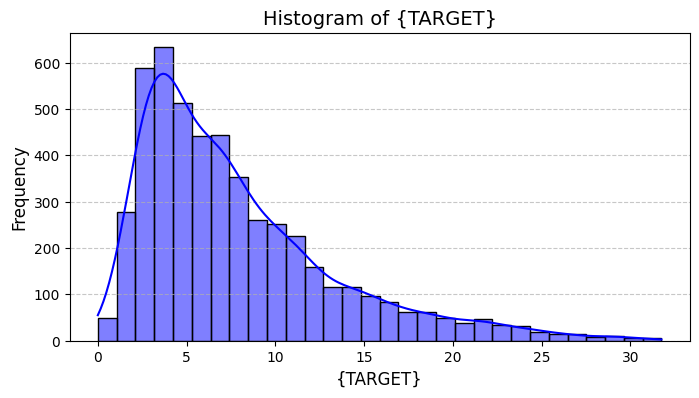

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns  # 如果还没导入 Seaborn

%matplotlib inline

TARGET = "CO2 uptake at 16 bar and 298K"  # 这是你想分析的列





#11111111111111111111111111111111111111111111111111111111
#这一段主要目的是绘制目标属性（TARGET）的直方图，帮助我们观察数据分布。

# add code here
# Plot histogram of the target
plt.figure(figsize=(8, 4)) #plt.figure() 创建一个新的图形（figure）。figsize=(8,4) 指定图形的大小，宽8英寸，高4英寸。


#使用 Seaborn 绘制直方图：，df[TARGET]，取 DataFrame 中的目标列（例如 CO₂ 吸附量）。
#kde=True 在直方图上叠加核密度估计曲线（Kernel Density Estimate），显示数据的平滑分布。
#bins=30，把数据分成 30 个柱子（bins），控制直方图的分辨率。
#color='blue' 设置柱子的颜色为蓝色。
sns.histplot(df[TARGET], kde=True, bins=30, color='blue')

# Add labels and title
plt.xlabel("{TARGET}", fontsize=12)       #x轴标签，这里是目标列名
plt.ylabel("Frequency", fontsize=12)      #y轴标签，这里表示“频率（Frequency）
plt.title("Histogram of {TARGET}", fontsize=14)     #图形标题，表示“目标列的直方图”。#fontsize 控制文字大小。

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)    #给图加上格线（grid），仅在 y 轴显示：linestyle='--' → 虚线，alpha=0.7 → 透明度 70%
plt.show()


Based on this histogram and the tail of the distribution, we will use 15 mmol CO$_2$ / g as the threshold for the uptake, thus binarizing our continuous target variable. We use this threshold to define a new column with binary values of 0 and 1 for bad and good materials.
ChatGPT said:

根据这个直方图以及分布的尾部，我们将 15 mmol CO₂/g 作为吸附量的阈值，从而把连续的目标变量二值化。
我们使用这个阈值来定义一个新的列，其中 0 表示“差”材料，1 表示“好”材料。

 $\color{Aqua}{\textsf{Short question}}$
 - add a column 'target_binary' that encodes whether a material is low performing (`0`) or high perfoming (`1`) by comparing the uptake with the `THRESHOLD`

 添加一列 'target_binary'，用来表示材料的性能：

如果吸附量低于阈值（THRESHOLD），记为 0（低性能）

如果吸附量高于阈值，记为 1（高性能）

解答（Python 代码示例）：

假设你已经定义了：

THRESHOLD = 15  # CO2 uptake 的阈值
TARGET = "CO2 uptake at 16 bar and 298K"


那么可以这样创建二值列：

df['target_binary'] = (df[TARGET] >= THRESHOLD).astype(int)

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> you can use <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html'>pd.cut</a>,
    <a href='https://stackoverflow.com/questions/4406389/if-else-in-a-list-comprehension'>list comprehension</a>, the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer'> binarizer in sklearn </a>...) </li>
    <li> a list comprehension example: <code> [1 if value > THRESHOLD else 0 for value in df[TARGET]] </code> </li>
</ul>
</details>

In [11]:
#这段代码主要是是基于 CO₂ 吸附量创建一个二值化目标列，标记“高性能材料”。

TARGET_BINARY = "target_binned" # name of the new binary target column
THRESHOLD = df[TARGET].quantile(0.9)  # 选择前10%的材料作为高性能。说明：这里用的是 动态阈值（基于数据分布的百分位数），而不是固定值（如 15 mmol/g）。

df[TARGET_BINARY] = (df[TARGET] > THRESHOLD).astype(int)
#df[TARGET] > THRESHOLD。对每一行判断 CO₂ 吸附量是否大于阈值，返回布尔值序列：True（高性能）/ False（低性能）
#.astype(int)，把布尔值转换为整数：True → 1，False → 0
#df[TARGET_BINARY] = ...， 把结果存入 DataFrame 的新列 "target_binned"

Now, we can perform the actual split into training and test set using stratified sampling.

 $\color{Aqua}{\textsf{Short question}}$
- select reasonable values for `XX` and `XY` and then perform the test/train splits. What do you consider when making this decision (think about what you would do with really small and really big datasets, what happens if you have only one test point, what happens to the model performance if you have more test points than training points)?
- why do we need to perform the split into a training and test set?
- would we use the test set to tune the hyperparameters of our model?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>The `size` arguments can either be integers or, often more convenient, decimals like 0.1</li>
    <li>When you perform the split into training and test set you need to trade-off bias (pessimistic bias due to little training data) and variance (due to little test data) </li>
    <li>A typical split cloud be 70/30, but for huge dataset the test set might be too big and for small datasets the training set might be too small in this way </li>
</ul>
</details>

In [ ]:
# add code here


In [14]:
#调用 sklearn.model_selection.train_test_split() 函数
#返回两个 DataFrame：df_train_stratified → 分层训练集，df_test_stratified → 分层测试集

df_train_stratified, df_test_stratified = train_test_split(
    df,             #要划分的数据集，这里是完整的 DataFrame df

    train_size=0.8,    #设置训练集所占比例或样本数量，
    test_size=0.2,     #设置测试集所占比例或样本数量，

    random_state=RANDOM_SEED,     #固定随机种子，保证每次划分结果一致
    stratify=df[TARGET_BINARY]    #分层抽样依据的列或数组
)

In [15]:
df_train_stratified.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K,target_binned
3941,SIVSOH_clean,0.00,2.49340,5.26253,5.26253,204.3600,0.000000,0.00000,0.146586,0.15194,...,3120.0,60.5736,152.7372,227.4600,222.8892,1.254526,3.215149,3.007026,3.172851,0
4325,MIHHER_clean,0.00,2.85919,15.91854,15.91854,1112.2400,0.000000,0.00000,0.393858,0.39684,...,14784.0,540.0192,1278.8736,1771.4688,1411.4256,1.097568,7.943100,2.558627,5.925292,0
2963,WOPROK_clean,0.00,3.56395,4.86457,4.64534,457.7720,0.000000,0.00000,0.168750,0.24404,...,2456.0,62.3540,141.4952,201.2248,218.2112,1.463088,4.818847,2.169466,3.721736,0
4892,WULJUJ_clean,1762.07,6.69559,13.25150,13.25042,96.7197,0.687366,0.60546,0.044866,0.03952,...,2448.0,71.5536,153.0144,220.7280,248.0016,0.657174,14.229026,2.920123,10.578180,0
4180,BEPRIZ_clean,1932.24,6.03558,10.21454,10.21454,0.0000,0.775985,0.59314,0.000000,0.00000,...,4584.0,92.7906,220.7436,327.8808,382.5468,0.541469,16.037532,5.377851,13.469770,1


In [16]:
df_test_stratified.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K,target_binned
4922,HAXMUP_clean,1028.690,5.76920,8.05193,8.05193,0.0000,0.301314,0.32756,0.000000,0.00000,...,828.0,37.6806,82.7976,99.0132,73.6404,0.212678,6.699793,1.302080,4.155805,0
4532,EMICUZ_clean,0.000,2.53854,4.07440,4.07440,31.1894,0.000000,0.00000,0.027065,0.04446,...,2732.0,63.8672,150.9200,221.7496,231.7484,1.293610,2.293200,0.877076,1.086896,0
4610,ZIKCED_clean,0.000,3.39179,6.17439,6.16782,673.8990,0.000000,0.00000,0.180019,0.22984,...,4208.0,97.9328,228.2304,328.8136,367.7376,0.817909,4.546784,2.593910,3.979876,0
2675,MUVGUG_clean,526.515,3.83720,5.30490,5.30439,234.2820,0.186115,0.18244,0.147533,0.14462,...,2588.0,55.9480,126.5880,182.6488,235.6628,3.278571,7.817154,4.441488,6.769900,0
1119,JOVWOI_clean,0.000,3.14601,4.43266,4.43262,163.4430,0.000000,0.00000,0.078921,0.16358,...,0.0,52.0832,99.0464,102.3168,0.0000,2.915916,3.475408,2.152572,2.443443,0


## 2. Exploratory data analysis (EDA)

After we have put the test set aside, we can give the training set a closer look.
在我们把测试集先分离出来之后，就可以仔细观察训练集了。

## 2.1 ydata profiling

> this part takes long so let's do it at home!

In [ ]:
# profile = ProfileReport(df_train_stratified, title="EDA Report", explorative=True)

In [ ]:
# profile.to_notebook_iframe()

In [ ]:
# Save to an html file
# profile.to_file("MOF_eda_report.html")

### 2.2 Removing redundant columns

We remove any feature that does not have variance across the dataset to reduce dimensionality.
Write a code below that makes a list of features (`redundant_features`) with zero variance.

我们会移除在整个数据集中没有方差的特征，
“没有方差的特征”指的是在整个数据集中取值完全相同的特征。

In [ ]:
# FILLME

In [17]:
# update feature set 显示移除零方差特征前的特征数量
#len(FEATURES)：计算当前特征列表 FEATURES 中的特征数量

#print(f"...")：用 f-string 输出信息，例如：

print(f"Number of features before: {len(FEATURES)}")

FEATURES = [feature for feature in FEATURES if not feature in redundant_features] #删除所有零方差特征，得到干净的特征集合
print(f"Number of features after: {len(FEATURES)}")

NameError: name 'FEATURES' is not defined

### 2.3. Correlations

 $\color{Aqua}{\textsf{Short question}}$
- Plot some features against the target property and calculate the Pearson and Spearman correlation coefficient (what is the different between those correlation coefficients?)
- What are the strongest correlations? Did you expect them?
- What can be a problem when features are correlated?
- *Optional:* Do they change if you switch from CO$_2$ uptake at high pressure to low pressure `CO2 uptake at 0.15 bar and 298K`?  Explain your observation.

To get the correlation matrices, you can use the `df.corr(method=)`method on your dataframe (`df`). You might want to calculate not the full correlation matrix but just the correlation of the features with the targets

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> To get the correlation with a target, you can use indexing. E.g. <code>df.corr(method='spearman')[TARGET]</code></li>
    <li> use <code>.sort_values()</code> method on the output of `df.corr()` to sort by the value of the correlation coefficient  </li>
    <li> Scatter plot of TARGET vs. one descriptor (e.g., Density) </li>
</ul>
</details>

In [ ]:
# add code here
# Calculate the correlation of all features with the target


## 3. Baselines

For machine learning, it is important to have some *baselines* to which one then compares the results of a model. Think of a classification model for some rare disease where we only have 1% postives. A classification model that only predictes the negatives *all the time* will still have a amazingly high accuracy. To be able to understand if our model is really better than such a simple prediction we need to make the simple prediction first. This is what we call a baseline.

A baseline could be a really simple model, a basic heuristic or the current state of the art (SOTA).
this. We will use a heuristic but if you aim for a publication, a baseline for you will be the state of the art model.

For this we use sklearn `Dummy` objects that simply calculate the mean, the median or the most frequent case of the training set, when you run the `fit()` method on them (which takes the features matrix $\mathbf{X}$ and the labels $\mathbf{y}$ as arguments.
This is, the prediction of a `DummyRegressor` with `mean` strategy will always be the mean, independent of the input (it will not look at the feature matrix!).

Instead of using those `sklearn` objects you could also just manually compute the the mean or median of the dataset. But we will use those objects as we can learn in this way how to use estimators in `sklearn` and it is also allows you to test your full pipeline with different (baseline) models.
What does this mean? In practice this means that you can use all the regression and classification models shown in the figure below in the same way, they will all have a `fit()` method that accepts `X` and `y` and a predict method that accepts `X` and returns the predictions.


<img src="https://scikit-learn.org/1.3/_static/ml_map.png" alt="ML Map" width="800"/>

The estimator objects can be always used in the same way

<img src="https://static.packt-cdn.com/products/9781789800265/graphics/d49a2e95-8f22-42ed-89f1-474b3d028787.png" alt="ML Map" width="400"/>

Using these objects, instead of the mean directly, allows you to easily swap them with other models in pipelines, where one chains many data transformation steps (see section 6).

### 3.1. Build dummy models

 $\color{Aqua}{\textsf{Short question}}$
- If you call `.fit(X, y)` on a `DummyRegressor` does it actually use the `X`? If not, why is there still the place for the `X` in the function? If yes, how does it use it?

 $\color{Aqua}{\textsf{Short question}}$
- Create [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) instances for  `mean`, `median`. (e.g. `dummyinstance = DummyRegressor(strategy='mean')`)
- Train them on the training data (`dummyinstance.fit(df_train[FEATURES], df_train[TARGET])`)

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to create <code>DummyRegressor</code> you can for example use <code> dummyregressor_mean = DummyRegressor(strategy='mean') </code> </li>
    <li> to see the implementation of the <code>DummyRegressor</code> you can check out <a href="https://github.com/scikit-learn/scikit-learn/blob/73732e5a0bc9b72c7049dc699d69aaedbb70ef0a/sklearn/dummy.py#L391"> the source code on GitHub</a> </li>
</ul>
</details>

In [ ]:
# your code here
# Build DummyRegressors
dummyregressor_mean = DummyRegressor(strategy='mean')
dummyregressor_median = DummyRegressor( #fillme

In [ ]:
# Fit Dummy Regressors
dummyregressor_mean.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
dummyregressor_median. #fillme

#### Evaluate the performance of the dummy models

 $\color{Aqua}{\textsf{Short questions}}$
- Calculate maximum error, mean absolute error and mean square error for the dummy regressors on training and test set. What would you expect those numbers to be?
- Do the actual values surprise you?
- What does this mean in practice for reporting of metrics/the reasoning behind using baseline models

It can be handy to store our metrics of choice in a nested dictionary ([Python dictionaries are key-value pairs](https://www.tutorialspoint.com/python/python_dictionary.htm)):

```python
{
    'dummyestimator1': {
                        'metric_a_key': metric_a_value,
                        'metric_b_key': metric_b_value
                    },
    'dummyestimator2': {
                        'metric_a_key': metric_a_value,
                        'metric_b_key': metric_b_value
                    },
 }
```

You will now write functions `get_regression_metrics(model, X, y_true)` that compute the metrics and return this dictionary for a given model. The `predict` method takes the feature matrix $\mathbf{X}$ as input.

In them, we calculate

$\mathrm {MAE} =\frac{\sum _{i=1}^{n}\left|Y_{i}-\hat{y}_{i}\right|}{n}.$

,

$\mathrm {MSE} = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.$

$\mathrm{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_i - \hat{Y}_i}{max (\epsilon,Y_i)} \right|$

where $\hat{y}$ are the predictions and, $Y_{i}$ the true values.

We also include maximum error which is a good indication for generalization in many cases.

See more information on [sklearn's Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error)



<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to perform a prediction using a estimator object, you can call <code> classifier.predict(X) </code> </li>
    <li> to calculate metrics, you can for example call <code>accuracy_score(true_values, predicted_values) </code> </li>
</ul>
</details>

In [ ]:
def get_regression_metrics(model, X, y_true):
    """
    Get a dicionary with regression metrics:

    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels
    """
    y_predicted = #fillme

    mae = #fillme
    mse = #fillme
    maximum_error = #fillme
    mape =  #fillme

    metrics_dict = {
        'mae': mae,
        'mse': mse,
        'max_error': maximum_error,
        'mape': mape
    }

    return metrics_dict

In [ ]:
dummy_regressors = [
    ('mean', dummyregressor_mean),
    ('median', dummyregressor_median)
]

In [ ]:
dummy_regressor_results_test = {} # initialize empty dictionary
dummy_regressor_results_train = {}

# loop over the dummy_regressor list
# if you have a tuple regressorname, regressor = (a, b) that is automatically expanded into the variables
# a = regressorname, b = regressor
for regressorname, regressor in dummy_regressors:
    print(f"Calculating metrics for {regressorname}")
    dummy_regressor_results_test[regressorname] = get_regression_metrics(regressor, df_test[FEATURES], df_test[TARGET])
    dummy_regressor_results_train[regressorname] = get_regression_metrics(regressor, df_train[FEATURES], df_train[TARGET])

In [ ]:
print("Dummy Regressor Results - Train & Test Set")

for regressorname, metrics in dummy_regressor_results_train.items():
    print(f"{regressorname} (Train): {metrics}")

for regressorname, metrics in dummy_regressor_results_test.items():
    print(f"{regressorname} (Test): {metrics}")


## 4. Building a linear regression model

In practice, we often rely on optimized libraries such as **scikit-learn** for machine learning models.  
They are fast, robust, and widely used.  

However, to really understand *what happens under the hood*, it is useful to **implement a simple linear regression model ourselves**.  

### Goals for this section:
- Implement **gradient descent** for linear regression.
- Compare results between **gradient descent** and the **closed-form (normal equation)** solution.
- Use **scikit-learn**'s `LinearRegression` as a baseline for comparison.


### 4.1 sklearn linear regression

Let's first use the sklearn model to get a good baseline for comparison.
You can see with few lines below, we can train a machine learning model.
The code is very flexible and you can essentially replace the linear regression with other models in sklearn.

Write the code below to train and evaluate a linear regression model using sklearn's `LinearRegression` class.

In [ ]:
# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model on the training data
# FILLME

# Evaluate the model on the training and test sets
# FILLME

# Print the results
print("Linear Regression Results - Train Set:", linear_regressor_results_train)
print("Linear Regression Results - Test Set:", linear_regressor_results_test)

### 4.1 Linear regression from scratch

Now, let's code a linear regression to see if we understand all parts. Specifically, we are going to code the gradient descent for our regressor to fit its parameters.

The class below supports:
- `method="normal"`: closed-form solution using the normal equation  
- `method="gd"`: gradient descent with configurable learning rate and iterations  
- Optional standardization of features for smoother optimization  


Code the missing part in the gradient descent.

In [ ]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True, standardize=False, method="normal",
                 lr=1e-2, n_iters=100, tol=1e-8, random_state=0):
        """
        method: "normal" (closed-form) or "gd" (gradient descent, MSE loss)
        """
        self.fit_intercept = fit_intercept
        self.standardize = standardize
        self.method = method
        self.lr = lr
        self.n_iters = n_iters
        self.tol = tol
        self.random_state = random_state
        self.coef_ = None
        self.intercept_ = 0.0
        self._x_mean = None
        self._x_std = None

    def _prepare_X(self, X, fit=False):
        X = np.asarray(X, dtype=float)
        if fit and self.standardize:
            self._x_mean = X.mean(axis=0, keepdims=True)
            self._x_std = X.std(axis=0, keepdims=True)
            self._x_std[self._x_std == 0] = 1.0
        if self.standardize:
            Xs = (X - self._x_mean) / self._x_std
        else:
            Xs = X
        if self.fit_intercept:
            Xs = np.c_[np.ones((Xs.shape[0], 1)), Xs]
        return Xs

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1,)

        Xp = self._prepare_X(X, fit=True)

        # NORMAL EQUATION
        if self.method == "normal":
            # theta = (X^T X)^{-1} X^T y  with ridge-like jitter for stability
            XT_X = Xp.T @ Xp
            # add tiny jitter to diagonal to avoid singular matrix in edge cases
            jitter = 1e-12 * np.eye(XT_X.shape[0])
            theta = np.linalg.pinv(XT_X + jitter) @ (Xp.T @ y)

        # GRADIENT DESCENT
        elif self.method == "gd":
            # Add your code here
            n_features = Xp.shape[1]
            theta = rng.normal(scale=0.01, size=n_features)
            prev_loss = np.inf
            for i in range(self.n_iters):
                y_pred = Xp @ theta
                residuals = y_pred - y
                loss = #FILLME
                if abs(prev_loss - loss) < self.tol:
                    break
                prev_loss = loss
                grad = (Xp.T @ residuals) / len(y)
                theta -= #FILLME
        else:
            raise ValueError("method must be 'normal' or 'gd'")

        # unpack theta into intercept and coefficients
        if self.fit_intercept:
            self.intercept_ = float(theta[0])
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self.standardize:
            Xs = (X - self._x_mean) / self._x_std
        else:
            Xs = X
        return self.intercept_ + Xs @ self.coef_

In [ ]:
# Initialize two Linear Regression model with different optimization methods
my_linear_regressor_gd = MyLinearRegression(fit_intercept=True, standardize=True, method="gd")
my_linear_regressor_cf = MyLinearRegression(fit_intercept=True, standardize=True, method="normal")

# Train the model on the training data
my_linear_regressor_gd.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
my_linear_regressor_cf.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

# Evaluate the model on the training and test sets
my_linear_regressor_gd_results_test = get_regression_metrics(
    my_linear_regressor_gd, df_train_stratified[FEATURES], df_train_stratified[TARGET]
)
my_linear_regressor_cf_results_test = get_regression_metrics(
    my_linear_regressor_cf, df_test_stratified[FEATURES], df_test_stratified[TARGET]
)

In [ ]:
# comparing results
print("Linear Regression Results - sklearn:", linear_regressor_results_test)
print("Linear Regression Results - cf:", my_linear_regressor_cf_results_test)
print("Linear Regression Results - gd:", my_linear_regressor_gd_results_test)


We can see how gradient descent results would be changing its parameters, namely learning rate and number of iterations.
Use the sliders to change the **learning rate** and the **number of iterations**.  
We’ll refit our custom gd model, plot the **loss vs. iteration**, and print evaluation metrics.

In [ ]:
my_linear_regressor_gd = MyLinearRegression(fit_intercept=True, standardize=True, method="gd",lr=1e-2, n_iters=1000)
my_linear_regressor_gd.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
my_linear_regressor_gd_results_test = get_regression_metrics(
    my_linear_regressor_gd, df_train_stratified[FEATURES], df_train_stratified[TARGET]
)
print("Linear Regression Results - gd:", my_linear_regressor_gd_results_test)

In [ ]:
from ipywidgets import interact, FloatLogSlider, IntSlider, fixed
from IPython.display import display

def run_gd_and_plot(lr, n_iters, df, FEATURES, TARGET, get_regression_metrics):
    model = MyLinearRegression(
        fit_intercept=True,
        standardize=True,
        method="gd",
        lr=lr,
        n_iters=n_iters,
        tol=1e-12,
        random_state=0
    )
    model.fit(df[FEATURES].values, df[TARGET].values)

    metrics = get_regression_metrics(model, df[FEATURES], df[TARGET])

    plt.figure(figsize=(6,4))
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE/2)")
    plt.title(f"lr={lr:.1e}, iters={n_iters}, MAE={metrics['mae']:.2f}, MAPE={metrics['mape']:.2f}")
    plt.plot(df[TARGET].values, model.predict(df[FEATURES].values), 'o', alpha=0.3)
    plt.plot(df[TARGET].values, df[TARGET].values, 'k--', label="y=x")
    plt.xlim(0.95*df[TARGET].min(), 1.05*df[TARGET].max())
    plt.ylim(0.95*df[TARGET].min(), 1.05*df[TARGET].max())
    plt.legend()
    plt.show()

In [ ]:
interact(
    run_gd_and_plot,
    lr=FloatLogSlider(value=1e-4, base=10, min=-5, max=0, step=0.1, description="learning rate"),
    n_iters=IntSlider(value=100, min=10, max=10000, step=50, description="iterations"),
    df=fixed(df_train_stratified),
    FEATURES=fixed(FEATURES),
    TARGET=fixed(TARGET),
    get_regression_metrics=fixed(get_regression_metrics)
)

You can find more information about gradient descent in this paper: [A high-bias, low-variance introduction to Machine Learning for physicists](https://doi.org/10.1016/j.physrep.2019.03.001)

Below is a schematic illustration from the paper showing how learning rate can affect the outcome of optimization.

![Gradient Descent Illustration](https://github.com/AI4ChemS/CHE-1147/blob/main/assets/GD_figure.jpg?raw=1)


$\color{Aqua}{\textsf{Short Exercise}}$
- what happens when the learning rate is too small?
- What about when it is too large?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> Too small leads to extremely slow convergance and too large can lead to overshoot!</li>
</ul>
</details>

## 5. Build a Kernel Ridge Regression Model

Let's build a simple [kernel ridge regression (KRR)](https://emtiyaz.github.io/pcml15/kernel-ridge-regression.pdf) machine learning model and train it with our raw data.
You can try different kernels, but we recommend to start with the Gaussian radial basis function ('rbf') kernel.

 $\color{Aqua}{\textsf{Short question}}$
- Do you expect this model to perform better than the dummy models?
- Train it and then calculate the performance metrics on the training and test set. How do they compare to the performance of the dummy models?
- What is the shape of the Kernel and of the weights? (you can check your answer by looking at the `dual_coef_` attribute of the KRR instance. You can get shapes of objects using the `shape` atrribute

In [ ]:
# Train the model with a Gaussian kernel
krr = KernelRidge(kernel='rbf')
krr.fit(#fillme)

In [ ]:
# get the metrics on the train and the test set using the get_regression_metrics functions (as above)

## 6. Evaluate the model performance in detail

We have trained our first machine learning model!
We'll first have a closer look at its performance, before learning how to improve it.

 $\color{Aqua}{\textsf{Short Exercise}}$
- Create a parity plot (true values against predictions)for the training and test data
- Plot a histogram of the distribution of the training and test errors on the training and test set. Plot the errors also as a function of the true value
- Let's assume we would like to use our model for pre-screening a library of millions of porous materials to zoom-in on those with the most promising gas uptake. Could you tolerate the errors of your model?
- Compare the parity plots for this model with the ones for the dummy models.
Use the plotting functions below the evaluate all the following models you train.

For this exercise, it can be handy to save the results in a dictionary, e.g.
```(python)
res_train = {
    'y true': [],
    'y pred': []
}
```

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
<ul>
    <li> If you want to use matplotlib to make the parity plots, you can use the <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html">hist2d function</a> </li>
    <li> To create the frequencies and the edges of a histogram, one can use <code>np.histogram</code></li>
</ul>
</details>

In [ ]:
# Create dictionaries with training and test results to create parity plots
res_train = {
    'y true': # fillme using the dataframe,
    'y pred': # fillme using the model prediction
}

res_test = {
    'y true': # fillme using the dataframe
    'y pred': # fillme using the model prediction
}

Now, lets calculate the errors

In [ ]:
res_train["error"] = res_train["y true"] - res_train["y pred"]
res_test["error"] = res_test["y true"] - res_test["y pred"]


Now, plot the parity plots and error distributions

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
If you want interactive plots, you can use the following code:
<pre><code>
hv.extension("bokeh")
hex_train = hv.HexTiles(res_train, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_test = hv.HexTiles(res_test, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_train + hex_test
</code>
</details>

In [ ]:
# plot it
hist_density(res_train['y true'], res_train['y pred'], xlabel='y true', ylabel='y pred', title='Train')

In [ ]:
hist_density(res_test['y true'], res_test['y pred'], xlabel='y true', ylabel='y pred', title='Test')

## 7. Improve the model

Our training set still has a couple of issues you might have noticed:
- The feature values are not scaled (different features are measured in different units ...)
- Some features are basically constant, i.e. do not contain relevant information and just increase the dimensionality of the problem
- Some feature distributions are skewed (which is more relevant for some models than for others ...)

$\color{Aqua}{\textsf{Short Question}}$
- Why might the scaling of the features be relevant for a machine learning model?

### 7.1. Standard scaling and building a first pipeline

Given that we will now go beyond training a single model, we will build [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which are objects that can collect a selection of transformations and estimators. This makes it quite easy to apply the same set of operations to different datasets. A simple pipeline might be built as follows

<img src="https://vitalflux.com/wp-content/uploads/2020/08/ML-Pipeline-Page-2-1024x307.png" alt="Pipeline" width="800"/>



 $\color{Aqua}{\textsf{Short Exercise}}$
- Build a pipline that first performs standard scaling and then fits a KRR. Call it `pipe_w_scaling`.
- Fit it on the training set
- Make predictions, calculate the errors and make the parity plots

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> the <code>fit</code>, <code>predict</code> methods also work for pipelines </li>
</ul>
</details>

In [ ]:
pipe_w_scaling = Pipeline(
   [
       ('scaling', StandardScaler()),
       ('krr', #fillme)
   ]
)

### 7.2. Hyperparameter optimization

A key component we did not optimize so far are hyperparameters. Those are parameters of the model that we usually cannot learn from the data but have to fix before we train the model.
Since we cannot learn those parameters it is not trivial to select them. Hence, what we typically do in practice is to create another set, a "validation set", and use it to test models trained with different hyperparameters.

The most common approach to hyperparameter optimization is to define a grid of all relevant parameters and to search over the grid for the best model performance.

$\color{Aqua}{\textsf{Short Exercise}}$
- Think about which parameters you could optimize in the pipeline. Note that your KRR model has two parameters you can optimize. You can also switch off some steps by setting them to `None'.
- For each parameter you need to define a resonable grid to search over.
- Recall, what k-fold cross-validation does. Run the hyperparameter optimization using 5-fold cross-validation (you can adjust the number of folds according to your computational resources/impatience. It turns out at k=10 is the [best tradeoff between variance and bias](https://arxiv.org/abs/1811.12808)).
Tune the hyperparameters until you are statisfied (e.g., until you cannot improve the cross validated error any more)
- Why don't we use the test set for hyperparameter tuning but instead test on the validation set?
- Evaluate the model performance by calculating the performance metrics (MAE, MSE, max error) on the training and the test set.
- *Optional:* Instead of grid search, try to use random search on the same grid (`RandomizedSearchCV`) and fix the number of evaluations (`n_iter`) to a fraction of the number of evaluations of grid search. What do you observe and conclude?

 $\color{DarkRed}{\textsf{Tips}}$
- If you want to see what is happening, set the `verbosity` argument of the `GridSearchCV` object to a higher number.

- If you want to speed up the optimization, you can run it in parallel by setting the `n_jobs` argument to the number of workers. If you set it to -1 it will use all available cores. *Using all cores might freeze your computer if you do not have enough memory*

- If the optimization is too slow, reduce the number of data points in your set, the number of folds or the grid size. Note that it can also be a feasible strategy to first use a coarser grid and the a finer grid for fine-tuning.

- For grid search, you need to define a parameter grid, which is a dictionary of the following form:
```(python)
param_grid = {
                    'pipelinestage__parameter': np.logspace(-4,1,10),
                    'pipelinestage': [None, TransformerA(), TransformerB()]
            }
```

- After the search, you can access the best model with `.best_estimator_` and the best parameters with `.best_params_` on the GridSearchCV instance. For example `grid_krr.best_estimator_`

- If you initialize the GridSearchCV instance with `refit=True` it will automatically train the model with all training data (and not only the training folds from cross-validations)

The double underscore (dunder) notation works recursively and specifies the parameters for any pipeline stage.
For example, `ovasvm__estimator__cls__C` would specifiy the `C` parameter of the estimator in the one-versus-rest classifier `ovasvm`.

You can print all parameters of the pipeline using `print(sorted(pipeline.get_params().keys()))`

<div class="alert alert-block alert-warning">
Be aware that tight grids will drastically increase the number of experiments you will run! In some cases, it can be useful to perform the optimization in steps, i.e., first use a coarse grid and then refine in interesting regions.
Alternatively, there are approached like <a href="https://www.jmlr.org/papers/volume18/16-558/16-558.pdf"> hyperband <a> that dynamically adjust the number of data points.
</div>

<details>
<summary> <font color='green'>Click here for hints about pipelines and grid search</font></summary>
<ul>
    <li> You can use the <code>np.logspace</code> function to generate a grid for values that you want to vary on a logarithmic scale </li>
    <li> There are two hyperparameters for KRR: the regularization strength <code>alpha</code> and the Gaussian width  <code>gamma</code> </li>
    <li> For the regularization strength, values between 1 and 1e-3 can be reasonable. For gamma you can use the median heuristic, gamma = 1 / median, or values between 1e-3 and 1e3</li>
</ul>
</details>

In [ ]:
# Define the parameter grid and the grid search object
param_grid = {
                    'scaling': [MinMaxScaler(), StandardScaler()], # test different scaling methods
                    'krr__alpha': #fillme,
                    'krr__#fillme': #fillme
            }

grid_krr = GridSearchCV(#your pipeline, param_grid=param_grid,
                        cv=#number of folds, verbose=2, n_jobs=2)

# optional random search
#random_krr = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
#                        cv=#number of folds, verbose=2, n_jobs=2
)

In [ ]:
# run the grid search by calling the fit method
grid_krr.fit(#fillme)
# optional random search
# random_krr.fit(#fillme)

In [ ]:
# get the performance metrics
get_regression_metrics(#fillme)

<details>
<summary> <font color='green'>Click here for some more information about hyperparameter optimization</font></summary>
Grid search is not the most efficient way to perform hyperparamter optimization. Even <a href="http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf">random search was shown to be more efficient</a>. Really efficient though are Bayesian optimization approaches like <a href='https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)'>TPE</a>. This is implemented in the hyperopt library, which is also installed in your conda environment.
</details>

<details>
<summary> <font color='green'>Click here for hyperparameter optimization with hyperopt (advanded and optional outlook)</font></summary>
    
<b>Import the tools we need</b>
<code>
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, mix, rand, anneal, space_eval
from functools import partial
</code>    

<b>Define the grid</b>
<code>
param_hyperopt = {
    "krr__alpha": hp.loguniform("krr__alpha", np.log(0.001), np.log(10)),
    "krr__gamma": hp.loguniform("krr__gamma", np.log(0.001), np.log(10)),
}
</code>

<b>Define the objective function</b>
<code>
def objective_function(params):
    pipe.set_params(
        **{
            "krr__alpha": params["krr__alpha"],
            "krr__gamma": params["krr__gamma"],
        }
    )
    score = cross_val_score(
        pipe, X_train, y_train, cv=10, scoring="neg_mean_absolute_error"
    ).mean()
    return {"loss": -score, "status": STATUS_OK}
</code>

<b>We will use a search in which we mix random search, annealing and tpe</b>
<code>
trials = Trials()
mix_search = partial(
   mix.suggest,
   p_suggest=[(0.15, rand.suggest), (0.15, anneal.suggest), (0.7, tpe.suggest)],
)
</code>

<b>Now, we can minimize the objective function.</b>
<code>
best_param = fmin(
        objective_function,
        param_hyperopt,
        algo=mix_search,
        max_evals=MAX_EVALES,
        trials=trials,
        rstate=np.random.RandomState(RANDOM_SEED),
    )
</code>

</details>

## 10. Influence of Regularization

## 8. Feature Engineering

Finally, we would like to remove features with low variance. This can be done by setting a variance threshold.

$\color{Aqua}{\textsf{Short Question}}$
    
- What is the reasoning behind doing this?
- When might it go wrong and why?

 $\color{Aqua}{\textsf{Short Exercise}}$
- Add a variance threshold to the pipeline (select the correct function argument)
- Use random search for hyperparameter optimization, retrain the pipeline, and calculate the performance metrics (max error, MAE, MSE) on the training and test set
- If you could improve the predictive performance, do not forget to also run the model for the Kaggle competition!

In [ ]:
# Define the pipeline
pipe_variance_threshold = Pipeline(
    # fillme with the pipeline steps
    [
        ('variance_treshold', VarianceThreshold(#fillme with threshold)),
        #fillme with remaining pipeline steps
    ]
)

In [ ]:
param_grid_variance_threshold = {
                    'scaling': [None, StandardScaler()],
                    'krr__alpha': #fillme,
                    'krr__#fillme': #fillme,
                    'variance_treshold__threshold': #fillme
            }

random_variance_treshold = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
                        cv=#number of folds, verbose=2, n_jobs=2)

In [ ]:
# Fit the pipeline and run the evaluation
random_variance_treshold.fit(#fillme)

$\color{Aqua}{\textsf{Short Exercise (optional)}}$
- replace the variance threshold with a model-based feature selection
`('feature_selection', SelectFromModel(LinearSVC(penalty="l1")))` or [any feature selection method that you would like to try](https://scikit-learn.org/stable/modules/feature_selection.html)

## 9. Saving the model

Now, that we spent so much time in optimizing our model, we do not want to loose it.

 $\color{Aqua}{\textsf{Short Exercise}}$
- use the [joblib library](https://scikit-learn.org/stable/modules/model_persistence.html) to save your model
- make sure you can load it again


In [ ]:
# Dump your model
joblib.dump(model, filename)

In [ ]:
# Try to load it again
model_loaded = joblib.load(filename)

 $\color{Aqua}{\textsf{Short Exercise}}$
- what happens if you set $\alpha$  to a really small or to large value? Why is this the case explain what the parameter means using the equation derived in the lectures?

 To test this, fix this value in one of your pipelines, retrain the models (re-optimizing the other hyperparameters) and rerun the performance evaluation.

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> Check the derivation for ridge regression and KRR in the notes. </li>
    <li> Also remember the loss landscapes we discussed in the lectures about LASSO. </li>
</ul>
</details>

## 11. Submit your best model to Kaggle

Join the [Kaggle competition](https://www.kaggle.com/competitions/molsim-2024-ml-challenge/host/launch-checklist) for this course!
For this you can:
- try to continue optimizing your KRR model
- try to use a new model ([browse the sklearn documentation](https://scikit-learn.org/) for ideas or check out [xgboost](https://xgboost.readthedocs.io/en/stable/)

The important parts for us here are:
- that you make an attempt to improve your model, discuss this attempt, and use proper models to measure potential improvement
- we will not grade you based on how "fancy" or model is or how well it performs but rather on whether you do something reasonable that is well motivated in your discussion
- you do not need to try both a model and continue optimizing your model. Doing one of them is, in principle, "enough"

Use then your best model to create a `submission.csv` with your predictions to join the competition and upload it to the competition site.


In [ ]:
kaggle_data = pd.read_csv('data/features.csv')
kaggle_predictions = #fillme.predict(kaggle_data[FEATURES])

In [ ]:
submission = pd.DataFrame({"id": kaggle_data["id"], "prediction": kaggle_predictions})

submission.to_csv("submission.csv", index=False)


## 12. Interpreting the model

Now, that our model performs decently, we would like to know which features are mainly responsible for this, i.e. how the model performs its reasoning.
> In CHE1147, we get back to this part in a couple of weeks. See course schedule for details.

One method to do so is the [permutation feature importance technique](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

$\color{Aqua}{\textsf{Short question}}$

We use both descriptors that encode the pore geometry (density, pore diameters, surface areas) as well as some that describe the chemistry of the MOF (the RACs).
- Would you expect the relative importance of these features to be different for prediction of gas adsorption at high vs low gas pressure?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> <a href="https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.8b02257">An article from Diego et al.</a> (10.1021/acs.chemmater.8b02257) gives some hints.</li>
</ul>
</details>

 $\color{Aqua}{\textsf{Short Exercise}}$
- Complete the function `_calculate_permutation_scores` (which we took from the `sklearn` package) and which is needed to calculate the permutation feature importance using the `permutation_importance` function.

In [ ]:
def _calculate_permutation_scores(estimator, X, y, col_idx, random_state,
                                  n_repeats, scorer):
    """Calculate score when `col_idx` is permuted. Based on the sklearn implementation

    estimator: sklearn estimator object
    X: pd.Dataframe or np.array
    y: pd.Dataframe or np.array
    col_idx: int
    random_state: int
    n_repeats: int
    scorer: function that takes model, X and y_true as arguments
    """
    random_state = check_random_state(random_state)

    X_permuted = X.copy()
    scores = np.zeros(n_repeats)
    # get the indices
    shuffling_idx = np.arange(X.shape[0])
    for n_round in range(n_repeats):
        # FILL BELOW HERE
        # shuffle them (fill in what you want to shuffle)
        random_state.shuffle(#fillme)

        # Deal with dataframes
        if hasattr(X_permuted, "iloc"):
            # .iloc selects the indices from a dataframe and you give it [row, column]
            col = X_permuted.iloc[shuffling_idx, col_idx]
            col.index = X_permuted.index
            X_permuted.iloc[:, col_idx] = col

        # Deal with numpy arrays
        else:
            # FILL BELOW HERE
            # array indexing is [row, column]
            X_permuted[:, col_idx] = X_permuted[#fillme]

        # Get the scores
        feature_score = scorer(estimator, X_permuted, y)

        # record the scores in array
        scores[n_round] = feature_score

    return scores

Nothing to change in the function below, it just call the `_calculate_permutation_scores` function you just completed.

In [ ]:
def permutation_importance(
    estimator,
    X,
    y,
    scoring="neg_mean_absolute_error",
    n_repeats=5,
    n_jobs=2,
    random_state=None,
):
    """Permutation importance for feature evaluation
    estimator : object
        An estimator that has already been :term:`fitted` and is compatible
        with :term:`scorer`.
    X : ndarray or DataFrame, shape (n_samples, n_features)
        Data on which permutation importance will be computed.
    y : array-like or None, shape (n_samples, ) or (n_samples, n_classes)
        Targets for supervised or `None` for unsupervised.
    scoring : string, callable or None, default=None
        Scorer to use. It can be a single
        string (see :ref:`scoring_parameter`) or a callable (see
        :ref:`scoring`). If None, the estimator's default scorer is used.
    n_repeats : int, default=5
        Number of times to permute a feature.
    n_jobs : int or None, default=2
        The number of jobs to use for the computation.
        `None` means 1 unless in a :obj:`joblib.parallel_backend` context.
        `-1` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    random_state : int, RandomState instance, or None, default=None
        Pseudo-random number generator to control the permutations of each
        feature. See :term:`random_state`.
    """
    # Deal with dataframes
    if not hasattr(X, "iloc"):
        X = check_array(X, force_all_finite="allow-nan", dtype=None)

    # Precompute random seed from the random state to be used
    # to get a fresh independent RandomState instance for each
    # parallel call to _calculate_permutation_scores, irrespective of
    # the fact that variables are shared or not depending on the active
    # joblib backend (sequential, thread-based or process-based).
    random_state = check_random_state(random_state)
    random_seed = random_state.randint(np.iinfo(np.int32).max + 1)

    # Determine scorer from user options.
    scorer = check_scoring(estimator, scoring=scoring)
    # get the performance score on the unpermuted data
    baseline_score = scorer(estimator, X, y)

    # run the permuted evaluations in parallel for each column
    scores = Parallel(n_jobs=n_jobs)(
        delayed(_calculate_permutation_scores)(
            estimator, X, y, col_idx, random_seed, n_repeats, scorer
        )
        for col_idx in range(X.shape[1])
    )

    # get difference two
    importances = baseline_score - np.array(scores)

    # return the results (dictionary)
    return Bunch(
        importances_mean=np.mean(importances, axis=1),
        importances_std=np.std(importances, axis=1),
        importances=importances,
    )


 $\color{Aqua}{\textsf{Short Exercise}}$
- Use your function to find the five most important features.
- Which are they? Did you expect this result?

In [ ]:
permutation_results = permutation_importance(#fillme)

In [ ]:
permutation_results["features"] = FEATURES
bars = hv.Bars(
    permutation_results, "features", ["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)
errors = hv.ErrorBars(
    permutation_results, "features", vdims=["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)

bars * errors


<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> To get the top <emph>n</emph> indices of an array <code>a</code>, you can use <code>np.argsort(a)[-n:]</code></li>
    <li> Get the feature names from the <code>FEATURES</code> list </li>
    <li> combined this might look like <code>np.array(FEATURES)[np.argsort(a)[-n:]]</code></li>
</ul>
</details>

<details>
<summary> <font color='green'>Click here for more information on model interpretation</font></summary>
The permutation feature importance technique is not a silver bullet, e.g. there are issues with correlated features.
However, it is likely <a href='https://explained.ai/rf-importance/'>a better choice than feature importance, like impurity decrease, derived from random forests</a>).
</details>